In [1]:
from importlib import reload
import hough_functions
from ultralytics import YOLO
from sklearn.cluster import KMeans

reload(hough_functions)

from hough_functions import LineDetector

import numpy as np
import pandas as pd
import csv
import cv2

/home/matteo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def slope_intercept(line):
    """
    :param line: Coordinates [[x1, y1, x2, y2]] that define a line.
    :return: [slope, intercept]
    """
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]


    slope = 0
    intercept = 0

    if y2-y1 != 0:
        slope = (x2 - x1) / (y2 - y1)
        intercept = x1 - slope * y1

    return [slope, intercept]

def calculate_x(y, slope, intercept):
    return y * slope + intercept

def calculate_distance(w0, w1, d0):
    '''
    :param w0: Width of the track in pixels at the edge of the screen (bottom)
    :param w1: Width of the track in pixels at the bottom of the detected object
    :param d1: Distance from the camera to w0 (in Feet)
    :return: Distance to w1
    '''
    return d0 * (w0/w1)

def height_width(image):
    '''
    :param image: An image imported through cv2.imread()
    :return: Two ints representing the height and width of the image in pixels respectively
    '''
    return image.shape[:2]

def k_cluster_lines(lines):
    """
    this is a function that will intake a vector of subvectors
    and then run k-means clustering on them to find the two lines
    that can be used to calculate the distance of an object
    :param lines: vector of subvectors containing [x1,y1,x2,y2]
    :return: slope and intercept for two values
    """
    X = pd.DataFrame(np.zeros(shape = (lines.shape[0], 2)))
    X.columns = ['slope','intercept']

    for i, line in enumerate(lines):
        X.iloc[i,:] = slope_intercept(line)

    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(X)
    X['group'] = kmeans.predict(X)

    return X


def find_line_equations(X):
    """
    meant to be used in conjunction with k_cluster_lines
    given dataframe of slopes, intercepts, and groups,
    identify the equations for the left and right rails
    :param X: dataframe returned from k_cluster_lines
    :return: left line slope and intercept, right line slope and intercept
    """
    for group in np.unique(X['group']):
        X_group = X[X['group'] == group]
        slope = X_group.mean(axis = 0)['slope']
        if slope < -0.05:
            left_line = X_group.mean(axis = 0).drop('group')
        elif slope > 0.05:
            right_line = X_group.mean(axis = 0).drop('group')

    return left_line, right_line


def find_x(slope, intercept, y):
    return y * slope + intercept


def distance_estimation(X, y0, y1, d0):
    """

    :param X: dataframe of X from find_line_equations(X)
    :param y0: yvalue at the bottom of the screen
    :param y1: yvalue at the bottom of the bounding box of an object
    :param d0: distance from camera to bottommost visible part of screen
    :return: estimation of distance from camera to object
    """
    left_line, right_line = find_line_equations(X)

    if left_line is None or right_line is None:
        return None

    widths = []
    for y in [y0, y1]:
        left_x = find_x(left_line.slope, left_line.intercept, y)
        right_x = find_x(right_line.slope, right_line.intercept, y)
        widths.append(right_x - left_x)

    return calculate_distance(widths[0], widths[1], d0)


def turn_guesstimation(left_slope, right_slope):
    """
    given slope of left and right line, determine direction of train tracks
    :param left_line: slope and intercept of left rail line
    :param right_line: slope and intercept of right rail line
    :return: guesstimation on turning left or right
    """
    if -left_slope / right_slope < .9:
        return "turning left"
    elif -left_slope / right_slope  > 1.1:
        return "turning right"
    else:
        return "straight away"




def putting_it_all_together(lines, y0, y1, d0):
    """

    :param lines: vector of subvectors with [x1,y1,x2,y2]
    :param y0: yvalue at the bottom of the screen
    :param y1: yvalue at the bottom of the bounding box of an object
    :param d0: distance from camera to bottommost visible part of screen
    :return:
    """

    X = k_cluster_lines(lines)
    left_line, right_line = find_line_equations(X)

    print(distance_estimation(X, y0, y1, d0))
    print(turn_guesstimation(left_line.slope, right_line.slope))

    return

In [6]:
##########################

# Detect objects and lines

##########################

#location = 'images/RailSem19_rs06120.png'
location = 'MASKED_IMAGE.jpg'

image = cv2.imread(location)
#model = YOLO('yolov8n.pt')
#results = model(location)
detector = LineDetector()
lines = detector.detect_lines_image(location, crop=False, output = False)
#putting_it_all_together(lines, 1700, 1000, 9.5)

In [14]:
##########################

# Mask everything except rails

##########################

import cv2
import numpy as np

# Convert image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range of hue values for the desired color
lower_hue = np.array([90, 50, 50])  # Lower bound for teal/blueish hue
upper_hue = np.array([130, 255, 255])  # Upper bound for teal/blueish hue


# Create a binary mask of pixels within the specified hue range
mask = cv2.inRange(hsv_image, lower_hue, upper_hue)

# Create a black image of the same size as the original image
result = np.zeros_like(image)

# Copy only the pixels from the original image that correspond to the desired hue
result[mask > 0] = image[mask > 0]

# Display the result
#cv2.imshow('Result', result)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
cv2.imwrite('MASKED_IMAGE.jpg', result)

True

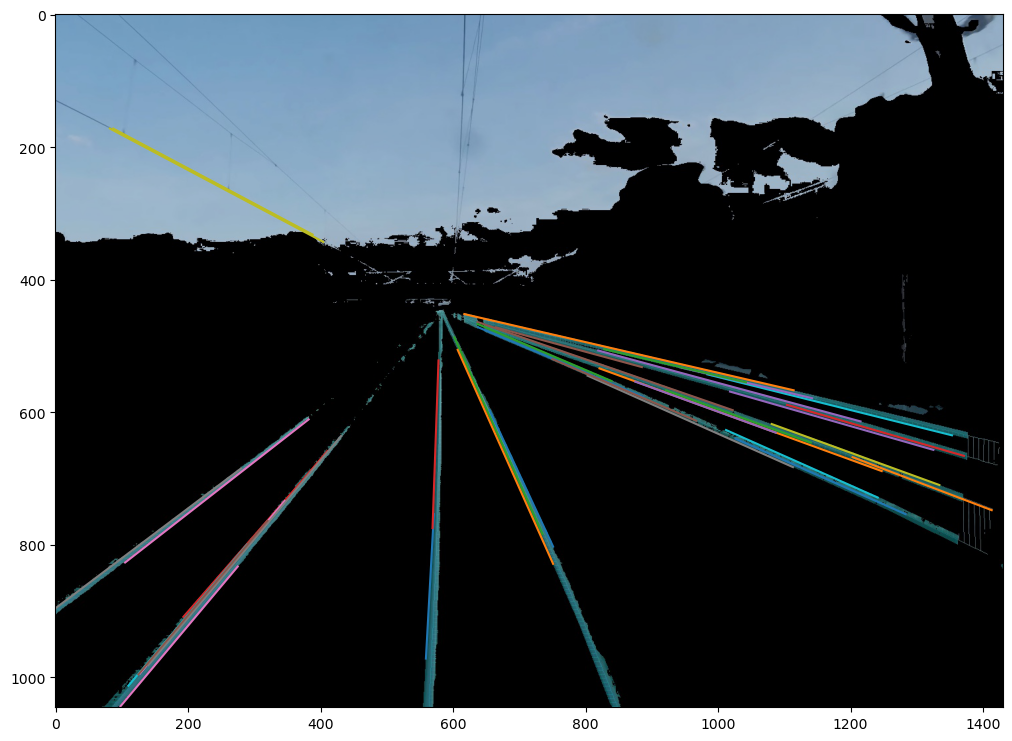

1046

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize = (16,9))

for line in lines:

    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]

    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1

    plt.plot([x1,x2],[y1,y2])
    
im1 = Image.open(location)
plt.imshow(im1)
plt.show()

im1.height

# use kmeans clustering to group the lines on the left track, right track, and horizontal lines
# take the average of the lines for the left track, 
# take the average of the lines for the right track
# remove the horiziontal lines
# use averaged lines for left and right as the lines of the tracks for calculation

In [5]:
##########################

# Detect objects and lines

##########################

image = cv2.imread(location)
#model = YOLO('yolov8n.pt')
#results = model(location)
detector = LineDetector()
lines = detector.detect_lines_image(location, crop=False)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize = (16,9))

for line in lines:
    
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    
    plt.plot([x1,x2],[y1,y2])
    
ana = Image.open(location)
plt.imshow(ana)
plt.show()

# use kmeans clustering to group the lines on the left track, right track, and horizontal lines
# take the average of the lines for the left track, 
# take the average of the lines for the right track
# remove the horiziontal lines
# use averaged lines for left and right as the lines of the tracks for calculation

In [4]:
##########################

# Loop through objects
# Calculate Distance
# Save to CSV

##########################

detected_objects = results[0].boxes
csv_file_name = 'detected_objects.csv'
object_names = results[0].names
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(['Class ID', 'Object Name','Confidence', 'X1', 'Y1', 'X2', 'Y2','Distance'])

    for box in detected_objects:
        class_id = box.cls[0].item()
        conf = box.conf[0].item()
        cords = box.xyxy[0].tolist()  # formatted as [x1, y1, x2, y2]
        object_name = object_names.get(class_id, 'Unknown')
        
        ##########################

        # Calculate Distance

        ##########################

        image_height = height_width(image)[0]
        bottom_object = cords[3]
        x1 = calculate_x_val(lines[0], bottom_object)
        x2 = calculate_x_val(lines[1], bottom_object)
        x11 = calculate_x_val(lines[0], image_height)
        x22 = calculate_x_val(lines[1], image_height)
        # Final distance value
        distance = calculate_distance((x22-x11), (x2-x1), 10)
        
        ##########################

        # Write to CSV

        ##########################       
        
        # Write the object data to the CSV file
        writer.writerow([class_id, object_name, conf, *cords, distance])



NameError: name 'results' is not defined

In [5]:
##########################

# Display Picture

##########################

detected_objects = results[0].boxes
object_names = results[0].names

# Draw bounding boxes on the image
for box in detected_objects:
    # Extract box coordinates
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    # Convert coordinates to integers
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    # Get class ID and confidence
    class_id = box.cls[0].item()
    conf = box.conf[0].item()
    # Get object name
    object_name = object_names.get(class_id, 'Unknown')
    # Draw bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put text showing class name and confidence
    cv2.putText(image, f'{object_name}: {conf:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(image, f'Distance: {distance:.2f}', (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
cv2.imwrite('processed_image.jpg', image)

NameError: name 'results' is not defined